默认情况下，NeuralProphet 对每年、每周和每天的季节性进行建模，这些季节性在所有时间戳中保持静态。通过条件季节性，我们使模型能够将季节性拟合到数据集的某些部分。

In [10]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, set_random_seed, df_utils

# 导入依赖
import warnings
import numpy as np

warnings.filterwarnings("ignore")

# Disable logging messages unless there is an error
set_log_level("ERROR")

In [3]:
data_location = "/home/ann/opt/iNeuralProphet/data"
df = pd.read_csv(data_location + "/wp_log_peyton_manning.csv")
df.head()

,ds,y
0,2007-12-10,9.5908
1,2007-12-11,8.5196
2,2007-12-12,8.1837
3,2007-12-13,8.0725
4,2007-12-14,7.8936


# 1. 自定义季节性

例如，我们可以定义两个每周季节性：一个用于赛季足球，一个用于淡季足球。足球赛季从九月开始，一月后结束。我们通过向输入 df 添加包含二进制值（0 和 1）的两列来解释这一点，具体取决于条件是否在给定时间戳激活。请注意，还可以添加 0..1 之间的浮点来模拟更柔和的过渡。

当我们定义替代的每周季节性时，我们禁用了模型的默认季节性。

In [5]:
df["ds"] = pd.to_datetime(df["ds"])
df["on_season"] = df["ds"].apply(lambda x: x.month in [9, 10, 11, 12, 1])
df["off_season"] = df["ds"].apply(lambda x: x.month not in [9, 10, 11, 12, 1])

period=7 意味着我们正在添加新的每周季节性。使用参数 condition_name= ，我们指定新添加的季节性应拟合到什么条件。即据月份这个“条件”来决定在特定的日期使用哪一种周模式。
代码的目的是让模型学习两种不同的“星期几效应”：一种适用于旺季（9月-次年1月），另一种完全不同的“星期几效应”适用于淡季（2月-8月）

傅里叶阶数 (fourier_order) 决定了季节性曲线的复杂度和灵活度。

•​工作原理​：傅里叶级数通过一系列正弦(sin)和余弦(cos)函数的组合来逼近任何周期性的波形。fourier_order决定了使用多少对这样的正弦余弦函数。

•​值越大​ -> 使用的正弦余弦函数对越多 -> 拟合的曲线越复杂、波动越大 -> 越容易捕捉到更细微的周期性变化，但也更容易过拟合。

•​值越小​ -> 使用的函数对越少 -> 拟合的曲线越平滑、越像一个简单的波 -> 更抗噪声，但可能无法捕捉复杂的模式。

​fourier_order=3意味着什么？​​

•它使用 ​3对​（即6个：sin1, cos1, sin2, cos2, sin3, cos3）正弦余弦函数来构建周季节性曲线。

•这是一个中等偏下的复杂度，能够捕捉一周内比较明显的波动（例如，周末和工作日的显著差异），但不会过度拟合那些非常细微的、可能只是噪声的日间变化。

•对于通常具有明显“周末效应”的数据（如销量、客流），fourier_order=3是一个常见且合理的起点

In [6]:
m = NeuralProphet(weekly_seasonality=False)
m.set_plotting_backend("plotly-static")
m.add_seasonality(
    name="on_season", period=7, fourier_order=3, condition_name="on_season"
)
m.add_seasonality(
    name="off_season", period=7, fourier_order=3, condition_name="off_season"
)
metrics = m.fit(df, freq="D")

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/237 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

当预测未知的未来时，未来 df 必须以与输入 df 相同的方式扩展。

In [7]:
future = m.make_future_dataframe(df, n_historic_predictions=365, periods=365)
future["on_season"] = future["ds"].apply(lambda x: x.month in [9, 10, 11, 12, 1])
future["off_season"] = future["ds"].apply(lambda x: x.month not in [9, 10, 11, 12, 1])
forecast = m.predict(df=future)

Predicting: |          | 0/? [00:00<?, ?it/s]

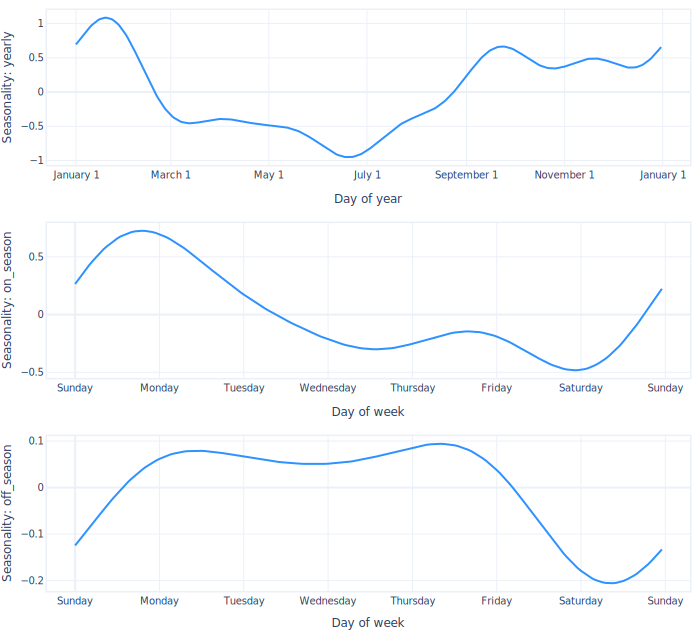

In [8]:
m.plot_parameters(components="seasonality")

# 预定义条件季节性

NeuralProphet 还提供了预定义的条件（季度、工作日/周末），这些条件通过简单的函数调用添加到输入 df 中

以下示例，我们希望合并每季度变化的每周季节性。

In [14]:
df = pd.read_csv(data_location + "/wp_log_peyton_manning.csv")
df = df_utils.add_quarter_condition(df)
df.head()

,ds,y,summer,winter,spring,fall
0,2007-12-10,9.5908,0,1,0,0
1,2007-12-11,8.5196,0,1,0,0
2,2007-12-12,8.1837,0,1,0,0
3,2007-12-13,8.0725,0,1,0,0
4,2007-12-14,7.8936,0,1,0,0


In [15]:
m = NeuralProphet(weekly_seasonality=False)
m.set_plotting_backend("plotly-static")
m.add_seasonality(
    name="weekly_summer", period=7, fourier_order=3, condition_name="summer"
)
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(
    name="weekly_winter", period=7, fourier_order=3, condition_name="winter"
)
m.add_seasonality(
    name="weekly_spring", period=7, fourier_order=3, condition_name="spring"
)
metrics = m.fit(df, freq="D")

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/237 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [16]:
future = m.make_future_dataframe(df, n_historic_predictions=365, periods=365)
future = df_utils.add_quarter_condition(future)
forecast = m.predict(df=future)

Predicting: |          | 0/? [00:00<?, ?it/s]

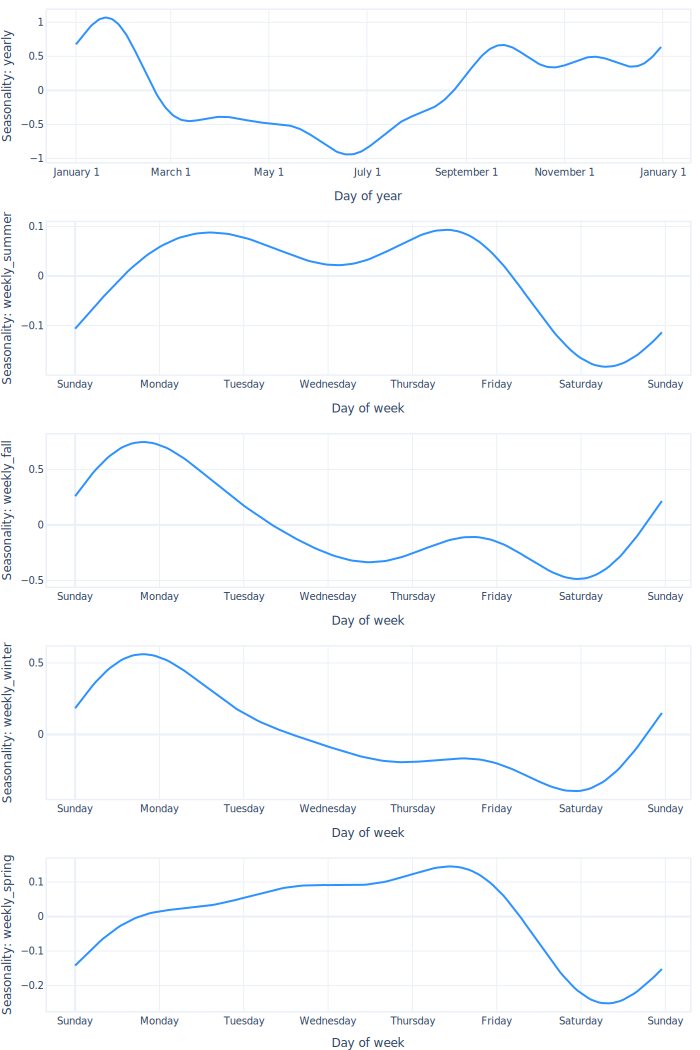

In [17]:
m.plot_parameters(components="seasonality")